In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from PIL import Image
%matplotlib inline

In [859]:
class Network(object):
    
    def __init__(self, layer_node): #layer_node is a list contains the number of nodes in each layer
        self.num_layer = len(layer_node)
        self.layer_node = layer_node
        self.input_node = []
        #self.node = [ np.random.randn(num_node,1) for num_node in layer_node ]
        self.weights = [ np.random.randn(next_node,previous_node+1) for next_node, previous_node in zip(layer_node[1:],layer_node[:-1]) ]
        
    def add_input_node(self,input_vector): #must be of size (n,1)
        if len(input_vector) == self.layer_node[0]: 
            self.input_node = np.append([[1]],input_vector, axis=0) # add bias node
        else:
            print "Input vector length invalid: given len {1}, need len {0}".format(self.layer_node[0], len(input_vector))
            
    def forward_propagation(self):
        output_value = self.input_node
        for weight in self.weights: 
            #print weight.shape
            #print output_vector.shape
            s = np.dot(weight, output_value)
            print "forward"
            output_value = np.append([[1]], output_transformation(s), axis=0) # add bias node -> size (n+1,1)
        #print "out:",output_vector
        #print output_value[1:][0][0]
        return output_value[1:][0][0] # we omit the bias node 
        
    def backpropagation(self,input_vector, output_vector):
        s = [] # vector before entering node
        x = [np.append([[1]],input_vector, axis=0)] # vector after entering node
        sensitivity = [ np.zeros([1,i]) for i in self.layer_node[1:] ]
        #print len(sensitivity)
        
        #feedforward, save all the node coefs of each layer
        for weight in self.weights:
            s.append(np.dot(weight, x[-1]))
            print "back"
            x.append(np.append([[1]], output_transformation(s[-1]), axis=0))
        #print x[-1][1:]
        #print np.square(x[-1][1:])
        sensitivity[-1] = 2.0*(x[-1][1:] - output_vector)*(1-np.square(x[-1][1:])) # omit the bias node 
        
        #backpropagation, compute sensitivity backward
        for layer_index in xrange(2, self.num_layer):
            w = self.weights[-layer_index+1]
            #print w
            #print w.shape
            #print sensitivity[-layer_index+1].shape
            
            sensitivity[-layer_index] = (1-np.square(x[-layer_index][1:]))*(np.dot(w.T,sensitivity[-layer_index+1]))[1:] #excluding the bias componnent which has the index 0
            
        return x, sensitivity
    
    def SGD(self, training_data, testing_data, eta, epochs): #stochastic gradient descent
        MSE_list = []
        predicted_result = []
        for epoch in xrange(epochs): 
            MSE = 0 
            gradient = [ np.random.randn(next_node,previous_node+1) 
                            for next_node, previous_node in zip(self.layer_node[1:],self.layer_node[:-1])]
            for index, row in training_data.iterrows():
                vector = np.array(row).reshape(3,1) 
                input_vector, output_vector = vector[:2], vector[2:]
                x, sensitivity = self.backpropagation(input_vector, output_vector)
                
                #print "sens ", len(sensitivity)
                #print "x ", len(x)
                #break
                
                for l in xrange(len(gradient)):
                    #print x[l].shape
                    #print sensitivity[l].shape
                    gradient[l] = np.dot(sensitivity[l],np.transpose(x[l]))
                    self.weights[l] = self.weights[l] - eta*gradient[l]
           
            #print "epoch ",epoch+1
            
            MSE, predicted_result = self.evaluate(testing_data)
            MSE_list.append(MSE)
     
            #print "Epoch {0}: MSE = {1}".format(epoch+1, MSE)
            #print
        return MSE_list, predicted_result
    
    
    
    def evaluate(self,testing_data):
        MSE = 0
        predicted_result = []
        for index, row in testing_data.iterrows():
            vector = np.array(row).reshape(3,1) 
            input_vector, output_vector = vector[:2], vector[2:]
            self.add_input_node(input_vector)
            predicted_value = self.forward_propagation()
            #print type(predicted_value)
            predicted_result.append(predicted_value)
            #print predicted_vector, output_vector
            #print "decision :", predicted_vector != output_vector
            MSE += predicted_value != output_vector #np.abs(predicted_vector - output_vector)
            #print predicted_value
        return float(MSE)/testing_data.shape[0], predicted_result

            

In [860]:
def output_transformation(z):
    #print z
    #print '_____'
    #print np.tanh(z)
    print z
    print 
    return np.tanh(z) # sigmoid function tanh

In [861]:
def str_to_float(df): 
    new_df = df.copy()
    return new_df.applymap(lambda x: float(x.replace(',','.')))

In [862]:
def normalize(df): 
    new_df = df.copy()
    new_df.x = new_df.x / np.max(new_df.x)
    new_df.y = new_df.y / np.max(new_df.y)
    #new_df[['x','y']] = new_df[['x','y']] / 500
    return new_df

In [863]:
df = pd.read_csv('donneespb4.txt',sep=' ',header=None)
df.columns = ['x','y','Value']

In [864]:
df = str_to_float(df)

In [865]:
df = normalize(df)

In [866]:
df.describe()

,x,y,Value
count,3000.000000,3000.000000,3000.00000
mean,0.507136,0.551742,0.36440
std,0.271767,0.222773,0.26765
min,0.200044,0.111215,0.20000
25%,0.243112,0.366198,0.20000
50%,0.413214,0.547152,0.20000
75%,0.766791,0.745741,0.80000
max,1.000000,1.000000,0.80000


In [867]:
binary_code = [np.sign(x-.5) for x in df.Value]

In [868]:
df['Class'] = binary_code

In [869]:
df.head()

,x,y,Value,Class
0,0.796366,0.269471,0.8,1
1,0.231017,0.376162,0.2,-1
2,0.219962,0.409765,0.2,-1
3,0.232364,0.605732,0.2,-1
4,0.525555,0.889831,0.8,1


In [870]:
t = df.drop('Value',1)

In [871]:
t.shape

(3000, 3)

In [872]:
test = t.copy()
test = test.iloc[:20,:]
test.head(10)

,x,y,Class
0,0.796366,0.269471,1
1,0.231017,0.376162,-1
2,0.219962,0.409765,-1
3,0.232364,0.605732,-1
4,0.525555,0.889831,1
5,0.209035,0.839043,-1
6,0.843655,0.127088,-1
7,0.960683,0.699131,1
8,0.265316,0.685395,-1
9,0.561246,0.877729,1


In [873]:
net = Network([2,10,1])

In [874]:
MSE, predicted_result = net.SGD(test,test,0.01,1)

back
[[ 1.3887666 ]
 [-0.07534233]
 [ 0.6382865 ]
 [-2.18380728]
 [-0.60368867]
 [ 0.20854327]
 [ 0.01941731]
 [-2.13469157]
 [-0.67024402]
 [-1.27249947]]

back
[[-1.55446857]]

back
[[ 0.75205405]
 [-0.69849466]
 [-0.31551495]
 [-1.84092022]
 [-0.60996694]
 [-0.84947481]
 [ 0.10811805]
 [-1.24832608]
 [-0.81895176]
 [ 0.42884844]]

back
[[ 1.8789923]]

back
[[ 0.69900299]
 [-0.6833055 ]
 [-0.33311921]
 [-1.85972081]
 [-0.63600592]
 [-0.89566372]
 [ 0.12697661]
 [-1.23741813]
 [-0.8514889 ]
 [ 0.46528264]]

back
[[ 1.86571025]]

back
[[ 0.48519437]
 [-0.51841355]
 [-0.34706463]
 [-2.02685522]
 [-0.81255555]
 [-1.03184763]
 [ 0.24559609]
 [-1.29345115]
 [-1.0325337 ]
 [ 0.46838535]]

back
[[ 1.50682439]]

back
[[ 0.41842719]
 [ 0.06217252]
 [ 0.08813022]
 [-2.47781363]
 [-1.11365716]
 [-0.75568095]
 [ 0.40682048]
 [-1.81614465]
 [-1.27045316]
 [-0.34689247]]

back
[[-0.9558936]]

back
[[ 0.23666532]
 [-0.40166984]
 [-0.47371889]
 [-2.196729  ]
 [-1.02281361]
 [-1.25812059]
 [ 0.3990402

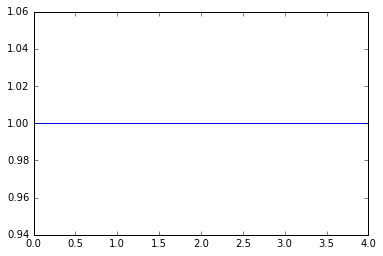

In [827]:
plt.plot(MSE)

In [828]:
test['Predicted'] = predicted_result

In [829]:
test.head(10)

,x,y,Class,Predicted
0,0.796366,0.269471,1,-0.955271
1,0.231017,0.376162,-1,-0.759627
2,0.219962,0.409765,-1,-0.741868
3,0.232364,0.605732,-1,-0.642989
4,0.525555,0.889831,1,-0.561350
5,0.209035,0.839043,-1,-0.439386
6,0.843655,0.127088,-1,-0.970907
7,0.960683,0.699131,1,-0.903125
8,0.265316,0.685395,-1,-0.600869
9,0.561246,0.877729,1,-0.595566


C:\Users\tphan.ENSC.001\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
  from ipykernel import kernelapp as app


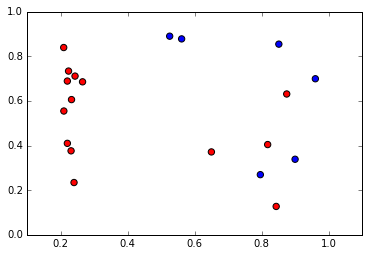

In [830]:
colormap = np.array(['b','b' ,'r'])
plt.scatter(test.x, test.y, c=colormap[test.Class], s=40)

C:\Users\tphan.ENSC.001\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
  from ipykernel import kernelapp as app


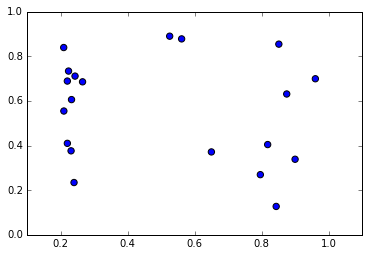

In [831]:
colormap = np.array(['b','b' ,'r'])
plt.scatter(test.x, test.y, c=colormap[test.Predicted], s=40)

In [832]:
set(test.Predicted)

{-0.970906676554109,
 -0.96164866197651033,
 -0.9552708785840216,
 -0.94056292010649811,
 -0.91024070516936906,
 -0.90312462842804475,
 -0.90029581521328872,
 -0.80535556209004688,
 -0.78536020056267974,
 -0.75962748521281886,
 -0.74186793671675222,
 -0.66494850898990909,
 -0.64298890023988764,
 -0.60086891263408859,
 -0.59556568787207975,
 -0.57651167768845457,
 -0.56953481756502533,
 -0.56135033210042418,
 -0.54150996095385584,
 -0.43938604766004363}